## Interactive streaming current data analysis and zeta potential calculator

### Background

The flow of an analyte over a charged surface could perturb the distribution of ions and counter ions close to the wall. Suppose there is a negatively charged surface (such as silicon dioxide) and a flow of phosphate buffer saline (PBS) over that. As getting close to the wall, the number of positively charged ions in the buffer increases. In other words, there is a rigid immobile layer of positively charged that does not move along with the flowing fluid that is known as the Stern layer. Above the Stern layer, there are loosely attached ions to the surface that moves slower than the fluid velocity that is known as the diffuse layer. These two layers with a higher density of positively charged ions try to compensate for the negative charge of the wall. This perturbation of the ion distribution induces a nano-scale electrical current known as the streaming current in a microchannel. On the other hand, the electric potential in the diffuse layer is known as the zeta potential which could be altered if specific molecules bind to the surface. Using this concept, the wall inside the microchannel is functionalized by capture probes, and the zeta potential is calculated using the recorded streaming current. Then a biological target is injected into the channel and the zeta potential is calculated again. The difference between the first and the last baselines is a signal from the biosensor.

The streaming current is measured by two platinum electrodes at the inlet and outlet of the microchannel. Due to the inevitable immobilization of different molecules inside the electrodes, the overall recorded streaming current drifts up or down and makes it uncertain to calculate the zeta potential. Hence, a train of Trapezoidal pulses of the analyte is injected into the system and the streaming current is recorded. The streaming current is as follows:

## The parameters needed to run the code
The following information is asked from the user. They are experimental parameters that I have set during my experiments. 

    Puls duration = 30 s
    Length of the channel = 3000 um
    Cross section = 10*25 um
    Lower pressure = 1.5 bar
    Higher pressure = 3 bar

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = [15, 5]

## Let's load some data

(It is real data from the experiments. The microchip was cleaned by RCA1 cleaning process and the baseline is measured by flowing 0.1xPBS by trapezoidal waveforms between 1.5 and 3 bar of upstream pressure.)

Here the data is read from my local directory and the columns are vectorized.

### Important remark

Due to practical complications, the recorded streaming current migth begin from the middle of a puls. This makes the data analysis less accurate. Hence, the first few data points must be skipped. On the other hand, the data aqcuisition system does not have a constant sampling rate and at some parts of a puls, the number of the data points could be less than the rest of the pulses. 

For this purpose, the data is loaded and is interpolated by a extra data points. The derivative is calculated and where it becomes zero for the first time, is where the data begins.

In [2]:
df0= pd.read_csv('/Users/moein/Desktop/Project_data.csv', parse_dates=['Time'])

# Streaming current
I0=df0['Current']

# Time
t0=pd.to_numeric(df0["Time"])

Text(0, 0.5, 'Streaming Current [A]')

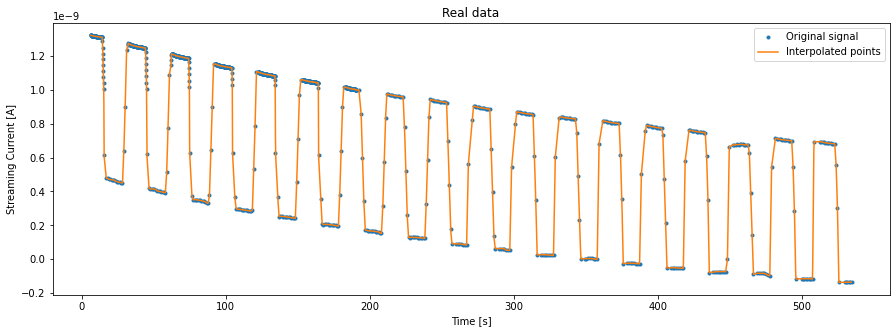

In [3]:
#Interpolation block
flinear0 = interpolate.interp1d(t0, I0)
xnew0 = np.arange(t0[0], t0[len(t0)-1], 0.2)
ylinear0 = flinear0(xnew0)


#Derivative calculation block
yprime0 = np.diff(ylinear0)/np.diff(xnew0)
xprime0 = np.zeros(len(xnew0)-1)
 

for i in range(len(yprime0)):
    
    xprime0[i] = (xnew0[i+1]+xnew0[i])/2

# Finding the beginning of a puls to skip the data points before that

index=np.zeros(100)
for i in np.arange(0, 100):
    skip= (np.abs(yprime0[i]-0))
    index[i]=skip
skip =np.where(index==(np.min(index))) 

# BINGO!
skip=int(skip[0])


# Let's load the data again and skip a few data points 
df1 = pd.read_csv('/Users/moein/Desktop/Project_data.csv',skiprows=[i for i in range(1,skip)], parse_dates=['Time'])

df1["Time"] = pd.to_numeric(df1["Time"])
df1.head()


#Interpolation block
t1=df1['Time']
I1 = df1['Current']
flinear1 = interpolate.interp1d(t1, I1)
xnew1 = np.arange(t1[0], t1[len(t1)-1], 0.2)
ylinear1 = flinear1(xnew1)

# Now let's plot the raw data and the interpolated points
plt.plot(t1, I1, '.', xnew1, ylinear1)
plt.legend(['Original signal', 'Interpolated points'])
plt.title('Real data')
plt.xlabel('Time [s]')
plt.ylabel('Streaming Current [A]')

## The data analysis
The data points between the high and low value of each puls are not of interest. 

The only interesting points are the one on the high and low side of the pulses. The whole work flow is as followed:

    1- The high and low points should be identified
    2- The points in the middle should be removed
    3- Each pulse, which is 30 seconds long, should be separated from the others
    4- The average of the high points whould be subtracted from the average of the low points to find Delta I
    5- The Zeta potential should be calculated for each puls
    6- The average of the zeta potential over time should be shown

In order to find the high and low points, the derivative is calculated on the interpolated lines. Thereafter, the data points where the derivative is close to zero are considered as the interetsing data points. 

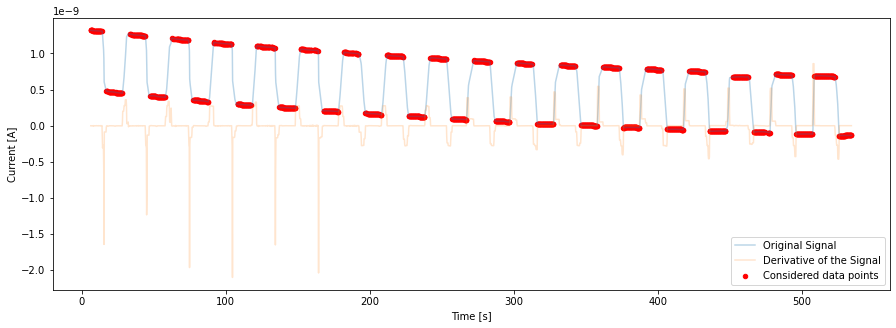

In [4]:
#Derivative calculation block
  
yprime1 = np.diff(ylinear1)/np.diff(xnew1)
    
xprime1 = np.zeros(len(xnew1)-1)
  
for i in range(len(yprime1)):
    
    xprime1[i] = (xnew1[i+1]+xnew1[i])/2
    
data1 = {'xprime1': xprime1, 'yprime1': yprime1}
df2 = pd.DataFrame(data1,columns=['xprime1','yprime1'])
df2.head()

time1=np.empty(len(xnew1))
time1[:] = np.nan
current1=np.empty(len(ylinear1))
current1[:] = np.nan


#Signal upper and lower bound detection

for i in range (len(yprime1)):
    if abs(yprime1[i])<0.3e-11:
        time1[i]=xnew1[i]
        current1[i]=ylinear1[i]
data2={'time1': time1, 'current1': current1}
df3 = pd.DataFrame(data2, columns=['time1', 'current1'])
df3.dropna()


#Plot block

df3.plot.scatter(x='time1', y='current1', color='red', label='Considered data points')

plt.plot(xnew1, ylinear1, alpha=0.3, label='Original Signal')

plt.plot(xprime1, yprime1, label='Derivative of the Signal', alpha=0.2)

plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.legend()
plt.show()

As seen above, the red points are the considered data points for the analysis.
Now it is time to identify the high and low values by asking the user to enter a number between the high and low bounds of the data plotted above. 

In [5]:
#Signal filteration block


Divide=float(input('Please insert a number between upper and lower bound of your signal'))
U = df3[df3['current1'] >= Divide]
L = df3[df3['current1'] < Divide]



m=18
t=np.empty((m, 150))
t[:] = np.nan

I=np.empty((m, 150))
I[:] = np.nan

Is=np.empty(m)
Is[:] = np.nan


Please insert a number between upper and lower bound of your signal0.8e-9


Now it is time to separate each puls from the others by asking the user to give the puls duration time. Thereafter, the geometrical and experimental parameters needed to calculate the zeta potential is asked from the user. 
In the end, the streaming current, zeta potential, error, and signal to noise ratio are calculated and printed. 

Please enter your puls duration30


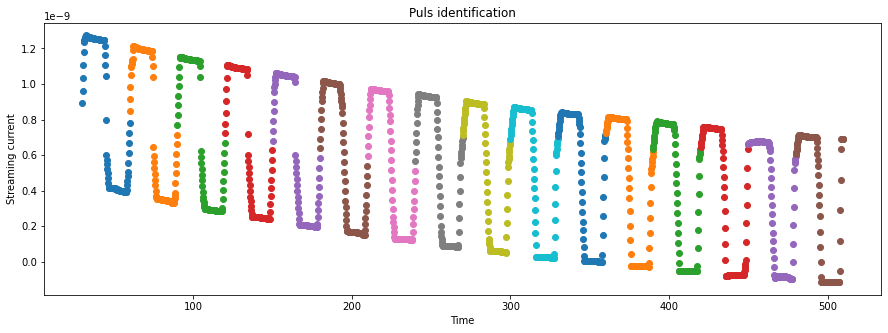

Please enter the lenght of the microchannel in microns:    3000
Please enter one side of the microchannel cross section in microns:   10
Please enter the second side of the microchannel cross section in microns:   25
Please enter the lower bound of the pressure pulse in bar:   1.5
Please enter the upper bound of the pressure pulse in bar:   3
|                                  |                          |
| Mean of Streaming Current        |   0.829115973388204 [nA]|
|                                  |                          |
---------------------------------------------------------------
|                                  |                          |
| Mean of Zeta Potential           |   99.9155011998327 [mV] |
|                                  |                          |
---------------------------------------------------------------
|                                  |                          |
| Error                            |   11.542013770036107     |
|                

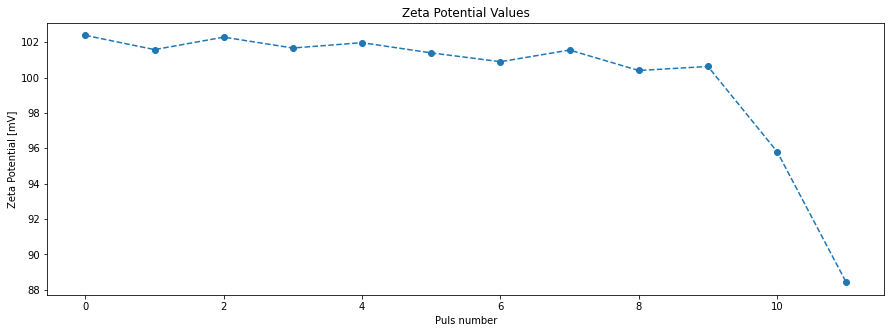

In [6]:
puls=float(input('Please enter your puls duration'))

data3={'xnew1': xnew1, 'ylinear1': ylinear1}
df4 = pd.DataFrame(data3, columns=['xnew1', 'ylinear1'])
for i in range (1, m-1):
    df5 = df4[(df4.xnew1 >= i*puls) & (df4.xnew1 <(i+1)*puls)]
    I[i, :]=df5['ylinear1']
    t[i, :]=pd.to_numeric(df5['xnew1'])
    
    plt.plot(t[i,:],I[i,:], 'o')
    plt.title('Puls identification')
    plt.xlabel('Time')
    plt.ylabel('Streaming current')
    
    
    
    yprime2 = np.diff(I[i,:])/np.diff(t[i, :])
    xprime2 = np.zeros(len(t[i,:])-1)
    for n in range(len(yprime2)):
    
        xprime2[n] = (t[i,:][n+1]+t[i,:][n])/2
    
    data5 = {'xprime2': xprime2, 'yprime2': yprime2}
    df7 = pd.DataFrame(data5,columns=['xprime2','yprime2'])


    time2=np.empty(len(t[i,:]))
    time2[:] = np.nan
    current2=np.empty(len(I[i,:]))
    current2[:] = np.nan

#Signal upper and lower bound detection

    for j in range (len(yprime2)):
        if abs(yprime2[j])<0.6e-10:
            time2[j]=t[i,:][j]
            current2[j]=I[i,:][j]
    data6={'time2': time2, 'current2': current2}
    df8 = pd.DataFrame(data6, columns=['time2', 'current2'])
    df8.dropna()



    

    #Signal filteration block
    U2 = df8[df8['current2'] >= Divide]
    L2 = df8[df8['current2'] < Divide]
    
#Streaming current calculation

    Umean2=U2["current2"].mean()
    Lmean2=L2["current2"].mean()
    Is3=Umean2-Lmean2
    Is[i] = Is3

plt.show()    

Is = Is[np.logical_not(np.isnan(Is))]

Ismean=Is.mean()    

#Zeta potential calculation
mu = 1.0665e-3
Length = float(input('Please enter the lenght of the microchannel in microns:    ')) 
a= float(input('Please enter one side of the microchannel cross section in microns:   '))
b= float(input('Please enter the second side of the microchannel cross section in microns:   '))
pL= float(input('Please enter the lower bound of the pressure pulse in bar:   '))
pU= float(input('Please enter the upper bound of the pressure pulse in bar:   '))

A = a*b*1e-12
perm =708e-12
delta_P = (pU-pL)*1e5
zeta=np.zeros(len(Is))
for i in range (len(Is)):
    Zeta =1000*Is[i]*Length*(1e-6)*mu/(A*perm*delta_P)
    zeta[i]=Zeta


    
SNR = np.mean(zeta)/3*np.std(zeta)



plt.plot(zeta, linestyle='--', marker='o')
plt.xlabel('Puls number')
plt.ylabel('Zeta Potential [mV]')
plt.title('Zeta Potential Values')
plt.show


ZP=zeta.mean()
print('===============================================================')
print('|                                  |                          |')
print('| Mean of Streaming Current        |  ', Ismean*1e9, '[nA]|')
print('|                                  |                          |')
print('---------------------------------------------------------------')
print('|                                  |                          |')
print('| Mean of Zeta Potential           |  ', ZP, '[mV] |')
print('|                                  |                          |')
print('---------------------------------------------------------------')
print('|                                  |                          |')
print('| Error                            |  ', 3*np.std(zeta), '    |')
print('|                                  |                          |')
print('---------------------------------------------------------------')
print('|                                  |                          |')
print('| Signal to Noise Ratio            |  ', SNR           , '    |')
print('|                                  |                          |')
print('===============================================================')